[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/condensation/condensation_playground.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/condensation/condensation_playground.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/condensation/condensation_playground.ipynb)

## Cloud Microphysics: Part 1
- Activation of aerosol particles into cloud droplets
- Exploring how size/composition affect condensational growth

Based on Example Figure from Pyrcel code documentation https://pyrcel.readthedocs.io/en/latest/examples/basic_run.html

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

## Droplet activation 
(for more info read Ch. 6 of Lohmann's _An Introduction to Clouds_)

#### Köhler curve:
- Curvature effect (Kelvin equation), describes the increase in vapor pressure over a curved surface
compared to a flat surface and how this depends on the surface tension and radius of the droplet. 
$e_s$ is the saturation vapor pressure over a surface of radius $r$, so $e_s(\infty)$ is the 
saturation vapor pressure over a flat surface. $\sigma$ is the surface tension, $\rho$ is the density
of the solution, $R_v$ is the gas constant for water vapor, and $T$ is the temperature.

$e_s(r) = e_s(\infty) \exp \left( \frac{2 \sigma}{r \rho R_v T} \right)$


<div class="alert alert-block alert-danger">
<b>Fun fact:</b> Based on the curvature considerations alone, saturation ratio in the atmosphere would need to be 5-10 for water to condense homogeneously, aka it would be extremely humid! Fortunately, we have aerosols that can serve as nuclei for water vapor to condense onto, and supersaturations in Earth's atmosphere rarely exceed 1%.
</div>

- Solute effect (Raoult's law), describes the reduction of vapor pressure over a flat surface due
to the presence of soluble material, aka aerosol.
$\kappa$ is refered to as the hygroscopicity, defined as the inverse of the water activity ($a_w$).
Again, $e_s$ is the saturation vapor pressure of pure water, and now $e_*$ is the vapor pressure 
of the solution with $n_s$ moles of solute and $n_w$ moles of water.

$\kappa = \frac{1}{a_w} = \frac{e_s(\infty)}{e_*(\infty)} = \frac{n_s + n_w}{n_w}$

The hygroscopicity (inverse of water activity) is defined as the ratio of the total number of 
moles of solute plus water to the number of moles of water.

- Putting it together, the Köhler curve, or $\kappa$-Köhler curve, describes the hygroscopic 
growth of particles, and the maximum of this curve, describes the point of activation from
an aerosol into a cloud droplet.
$S$ is the saturation ratio, which is usually linerarized as follows:

$S(r) = \frac{e_*(r)}{e_s(\infty)} \approx 1 + \frac{a}{r} - \frac{b}{r^3}$

<img src="./kohler_curve.svg" width="500">
Fig 6.11 from Lohmann. You can see a characteristic Köhler curve with the critical radius ($r_{act}$) and supersaturation ($S_{act}$) which separate the stable (aerosol or "solution droplet") and unstable (cloud droplet) regimes labeled.


<div class="alert alert-block alert-info">
<b>Other considerations:</b> Surface tension: The surface tension $\sigma$ in the Kelvin equation is usually assumed as constant $\sigma = \sigma_w = 72$ mN, but complex chemistry of the aerosol can sometimes actually
modify the effective surface tension of the growing cloud droplet.
</div>


## PySDM parcel model widget

In this homework assignment, and with this `PySDM` example notebook, you have the chance to explore how particle size, number concentration, and chemical composition, influence the bulk properties of a cloud by using a parcel model.

A parcel model takes a parcel of air and lifts it adiabatically, greatly simplifying the dynamics taking place in a real cloud, but resolving the microphysical processes we are interested in exploring here.

We initialize this parcel with a bimodal aerosol composed of two lognormal modes. The first mode is fixed, while the widget will let you play with the properties of the second mode. The default configuration represents a typical case in a marine environment. The first mode is smaller, more numerous sulfate aerosol, and the second mode is larger radii, less numerous, highly hygroscopic sea salt aerosol. 

You can play around with the widget at the bottom to change the initial aerosol properties, while keeping the dynamics fixed (i.e. updraft velocity `w = 1 * si.m / si.s` or temperature `T0 = 274 * si.K`). 

In [2]:
# import functions for creating interactive widget
from PySDM_examples.utils import widgets
import numpy as np
from numpy import errstate
import os

# import PySDM tools for initializing and running a cloud parcel model
from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity,
    ParticleSizeSpectrumPerVolume, ParticleVolumeVersusRadiusLogarithmSpectrum
)

# import tools for running and plotting this tutorial
from PySDM_examples.Pyrcel.settings import Settings
from PySDM_examples.Pyrcel.simulation import Simulation
from PySDM_examples.Pyrcel.profile_plotter import ProfilePlotter

In [3]:
# create progress bar for widget
progbar = widgets.IntProgress(min=0, max=100, description='%')

In [4]:
# create initial aerosol distribution
# run cloud parcel model
# save and plot results

# k2, N2, and r2 are the hygroscopicity, number concentration, and mean radius
# of the second Lognormal aerosol mode 
def demo(*, _freezer, _k2, _N2, _r2):
    with _freezer:
        with errstate(all='raise'):
            settings = Settings(
                dz = 1 * si.m,
                n_sd_per_mode = (10, 10),
                aerosol_modes_by_kappa = {
                    .54: Lognormal(
                        norm_factor=850 / si.cm ** 3,
                        m_mode=15 * si.nm,
                        s_geom=1.6
                    ),
                    _k2: Lognormal(
                        norm_factor=_N2 / si.cm ** 3,
                        m_mode=_r2 * si.nm,
                        s_geom=1.2
                    )
                },
                vertical_velocity = 1.0 * si.m / si.s,
                initial_pressure = 775 * si.mbar,
                initial_temperature = 274 * si.K,
                initial_relative_humidity = 0.98,
                displacement = 250 * si.m,
                formulae = Formulae(constants={'MAC': .3})
            )
            dry_radius_bin_edges = np.logspace(
                np.log10(1e-3 * si.um),
                np.log10(5e0 * si.um),
                33, endpoint=False
            )
            simulation = Simulation(
                settings,
                products=(
                ParcelDisplacement(
                    name='z'),
                AmbientRelativeHumidity(
                    name='S_max', unit='%', var='RH'),
                AmbientTemperature(
                    name='T'),
                ParticleSizeSpectrumPerVolume(
                    name='dry:dN/dR', radius_bins_edges=dry_radius_bin_edges, dry=True),
                ParticleVolumeVersusRadiusLogarithmSpectrum(
                    name='dry:dV/dlnR', radius_bins_edges=dry_radius_bin_edges, dry=True),
                ),
            )
            output = simulation.run((widgets.ProgbarUpdater(progbar, settings.output_steps[-1]),))

        with errstate(invalid='ignore'):
            plotter = ProfilePlotter(settings)
            plotter.plot(output)
            plotter.show()


## Widget

Play around with the widget and change the hygroscopicity ($\kappa_2$), number concentration ($N_2$), and mean radius ($r_2$) of the second ("sea salt") mode. 

<div class="alert alert-block alert-info">
<b>Note:</b> Running the parcel model takes a few seconds, so be patient after you move one of the sliders.</div>

The plots generated show (on the left) the profile of supersaturation ($S-1$, black) and temperature ($T$, red) and (on the right) profiles of droplet radius for each super particle. In pink are particles from the first mode (sulfate) and in blue are particles from the second mode (in the default case, sea salt).

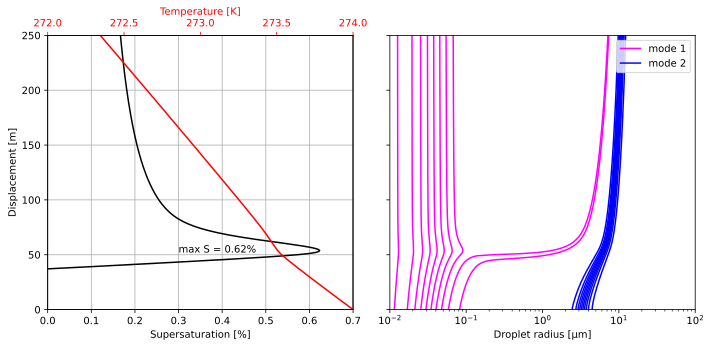

In [5]:
# create widget
# use to explore how the hygroscopicity, number concentration, and mean radius
# of the initial aerosol distribution affect the bulk parcel properties
# like maximum supersaturation and temperature profile

style = {'description_width': 'initial'}
k2 = widgets.FloatSlider(value=1.2, min=0.2, max=1.4, step=0.1, description='κ2',
                        continuous_update=False, readout_format='.1f', style=style)
N2 = widgets.IntSlider(value=10, min=5, max=50, step=5, description='N2 (cm-3)',
                        continuous_update=False, style=style)
r2 = widgets.IntSlider(value=850, min=200, max=1000, step=50, description='r2 (nm)',
                        continuous_update=False, style=style)
sliders = widgets.HBox([k2, N2, r2])
freezer = widgets.Freezer([k2, N2, r2])
inputs = {'_freezer': freezer, '_k2': k2, '_N2': N2, '_r2': r2}

if 'CI' not in os.environ:
    widgets.display(sliders, progbar, widgets.interactive_output(demo, inputs))
else:
    demo(**{k:v.value for k,v in inputs.items()})

## Questions

1. Extremes: Which combination of (changeable) parameters leads to the largest maximum supersaturation? Which to the smallest? Why?

2. Sensitivity: Is the cloud more sensitive to changes in aerosol size, number, or composition? Explain how you are measuring this.

3. Albedo: The albedo of a cloud is very dependent on the size of the individual droplets it is composed of. 
We can express the cloud albedo ($\alpha$) in terms of the cloud optical thickness ($\tau$) and a dimensionless asymmetry parameter ($g$)
that describes the relative amount of radiation that is forward-scattered vs. backscattered. 
$$\alpha = \frac{(1-g) \tau}{2 + (1-g)\tau}$$
Cloud droplets (order 1-10$\mu$m) tend to be strongly forward-scattering with an asymmetry parameter around $g=0.85$.
The cloud optical thickness can be written in terms of the liquid water path through the cloud (LWP) and effective radius of the droplets ($r_e$).
$$\tau = \frac{3 LWP}{2 \rho_w r_e}$$
<ol type="a">
  <li>Write down an expression for the cloud albedo. Assuming a fixed liquid water path, what is the sensitivity of albedo to droplet effective radius? This sensitivity is known as the "Twomey effect."</li>
  <li>Describe how the albedo would change given changes to the initial aerosol size distribution. </li>
</ol>

4. Real-world pollution regulations: How would you expect temperatures in Los Angeles to change if a policy was implemented that cut pollution in half. You can assume that this policy will also reduce the number of aerosols that can serve as cloud nuclei in half. Qualitative answers are good.